In [1]:
import ccxt
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import tz
import matplotlib.pyplot as plt

import json
import time
import os
import sys

In [2]:
src_path = '../src/'
sys.path.append(os.path.abspath(src_path))
import func_get
import func_signal
import func_backtest

In [3]:
start_ts = time.time()

In [4]:
interval_dict = {
    '1m': 1,
    '5m': 5,
    '15m': 15,
    '30m': 30,
    '1h': 60,
    '2h': 120,
    '4h': 240,
    '1d': 1440
}

In [5]:
with open('../../../_keys/ftx/read.json') as keys_file:
    keys_dict = json.load(keys_file)
    
exchange = ccxt.ftx({'apiKey': keys_dict['apiKey'],
                     'secret': keys_dict['secret'],
                     'enableRateLimit': True})

### Config

In [6]:
project_name = 'messi_revert'

In [7]:
start_date = dt.datetime(2022, 1, 1)
start_hour = 1
end_date = dt.datetime.today() - dt.timedelta(days=1)
reinvest_profit_flag = True

In [8]:
config_params = {
    'safety_ohlcv_range': 1000,
    'action_timeframe': '2h',
    'target_side': ['buy', 'sell'],
    'base': {
        'symbol': ['ETH-PERP'],
        'open': {
            '2h': {
                'tma': {
                    'check': ['check_signal_side_change'],
                    'look_back': 1,
                    'windows': 50,
                    'revert': True
                }
            }
        },
        'close': {
            '2h': {
                'tma': {
                    'check': ['check_signal_side'],
                    'look_back': 1,
                    'windows': 50,
                    'revert': True
                }
            }
        }
    },
    'lead': {
        'symbol': [],
        'open': {
        },
        'close': {
        }
    },
    'tp': {
        'stop_percent': 100,
        'price_percent': None,
        'signal': None,
    },
    'sl': {
        'stop_percent': 100,
        'price_percent': None,
        'signal': None
    },
    'action_percent': 100,
    'leverage': 1,
    'taker_fee_percent': 0.07
}

### Get data

In [9]:
ohlcv_df_dict = func_get.get_data(exchange, start_date, end_date, start_hour, interval_dict, config_params)

base: timeframe 1/1 symbol 1/1 date 1/342
base: timeframe 1/1 symbol 1/1 date 2/342
base: timeframe 1/1 symbol 1/1 date 3/342
base: timeframe 1/1 symbol 1/1 date 4/342
base: timeframe 1/1 symbol 1/1 date 5/342
base: timeframe 1/1 symbol 1/1 date 6/342
base: timeframe 1/1 symbol 1/1 date 7/342
base: timeframe 1/1 symbol 1/1 date 8/342
base: timeframe 1/1 symbol 1/1 date 9/342
base: timeframe 1/1 symbol 1/1 date 10/342
base: timeframe 1/1 symbol 1/1 date 11/342
base: timeframe 1/1 symbol 1/1 date 12/342
base: timeframe 1/1 symbol 1/1 date 13/342
base: timeframe 1/1 symbol 1/1 date 14/342
base: timeframe 1/1 symbol 1/1 date 15/342
base: timeframe 1/1 symbol 1/1 date 16/342
base: timeframe 1/1 symbol 1/1 date 17/342
base: timeframe 1/1 symbol 1/1 date 18/342
base: timeframe 1/1 symbol 1/1 date 19/342
base: timeframe 1/1 symbol 1/1 date 20/342
base: timeframe 1/1 symbol 1/1 date 21/342
base: timeframe 1/1 symbol 1/1 date 22/342
base: timeframe 1/1 symbol 1/1 date 23/342
base: timeframe 1/1 

base: timeframe 1/1 symbol 1/1 date 191/342
base: timeframe 1/1 symbol 1/1 date 192/342
base: timeframe 1/1 symbol 1/1 date 193/342
base: timeframe 1/1 symbol 1/1 date 194/342
base: timeframe 1/1 symbol 1/1 date 195/342
base: timeframe 1/1 symbol 1/1 date 196/342
base: timeframe 1/1 symbol 1/1 date 197/342
base: timeframe 1/1 symbol 1/1 date 198/342
base: timeframe 1/1 symbol 1/1 date 199/342
base: timeframe 1/1 symbol 1/1 date 200/342
base: timeframe 1/1 symbol 1/1 date 201/342
base: timeframe 1/1 symbol 1/1 date 202/342
base: timeframe 1/1 symbol 1/1 date 203/342
base: timeframe 1/1 symbol 1/1 date 204/342
base: timeframe 1/1 symbol 1/1 date 205/342
base: timeframe 1/1 symbol 1/1 date 206/342
base: timeframe 1/1 symbol 1/1 date 207/342
base: timeframe 1/1 symbol 1/1 date 208/342
base: timeframe 1/1 symbol 1/1 date 209/342
base: timeframe 1/1 symbol 1/1 date 210/342
base: timeframe 1/1 symbol 1/1 date 211/342
base: timeframe 1/1 symbol 1/1 date 212/342
base: timeframe 1/1 symbol 1/1 d

### Add signal

In [10]:
ohlcv_df_dict = func_signal.add_signal(start_date, ohlcv_df_dict, interval_dict, config_params)

base add tma to ETH-PERP 2h


### Back test

In [11]:
action_time_list = func_get.gen_action_time_list(config_params, ohlcv_df_dict)
max_open_timeframe = func_backtest.get_max_open_timeframe(config_params, interval_dict)

In [12]:
budget = 100

transaction_dict = {
    'symbol': [],
    'side': [],
    'amount': [],
    'open_time': [],
    'open_price': [],
    'close_time': [],
    'close_price': [],
    'value': [],
    'notional': [],
    'profit': [],
    'profit_percent': []
}

position_dict = {}

if reinvest_profit_flag == True:
    budget_dict = {
        'time': [],
        'budget': []
    }
    
max_drawdown = 0

In [13]:
if reinvest_profit_flag == True:
    min_budget = budget

time_count = 0

for signal_time in action_time_list:
    action_time = signal_time + dt.timedelta(minutes=interval_dict[config_params['action_timeframe']])
    
    time_count += 1
    print(f"Time {action_time}: progress {time_count}/{len(action_time_list)}")

    '''
    Close positions
    '''
    for symbol in [x for x in position_dict.keys()]:
        print(f"  {symbol}")
        budget, max_drawdown, position_dict, transaction_dict = func_backtest.close_position(symbol, signal_time, max_drawdown, config_params, budget, reinvest_profit_flag, ohlcv_df_dict, position_dict, transaction_dict, interval_dict)

    '''
    Open positions
    '''
    max_position = int(1 / (config_params['action_percent'] / 100))

    for symbol in [x for x in config_params['base']['symbol'] if x not in position_dict.keys()][:max_position]:
        print(f"  {symbol}")
        position_dict = func_backtest.open_position(symbol, signal_time, max_open_timeframe, config_params, budget, ohlcv_df_dict, position_dict, interval_dict)    
    
    '''
    Update budget
    '''
    if reinvest_profit_flag == True:
        budget_dict['time'].append(signal_time)
        budget_dict['budget'].append(budget)

        if budget < min_budget:
            min_budget = budget

    if budget <= 0:
        print(f"Out of money at {action_time}")
        break
        
'''
Clear final position
'''
opened_symbol = list(position_dict.keys())

for symbol in opened_symbol:
    print(f" Clear {symbol} position")
    
    side = position_dict[symbol]['side']
    ohlcv_df = ohlcv_df_dict['base'][config_params['action_timeframe']][symbol]
    current_ohlcv_df = ohlcv_df[ohlcv_df['time'] == signal_time].reset_index(drop=True)
    close_price = current_ohlcv_df.loc[0, 'close']
    close_percent = 100
    
    budget, position_dict, transaction_dict = func_backtest.update_close_position(symbol, side, close_price, close_percent, signal_time, config_params, budget, reinvest_profit_flag, position_dict, transaction_dict, interval_dict)

Time 2022-01-01 03:00:00: progress 1/2100
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 05:00:00: progress 2/2100
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 07:00:00: progress 3/2100
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 09:00:00: progress 4/2100
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 11:00:00: progress 5/2100
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 13:00:00: progress 6/2100
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 15:00:00: progress 7/2100
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 17:00:00: progress 8/2100
  ETH-PERP
     base ETH-PERP check_signal_side_

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-16 07:00:00: progress 183/2100
  ETH-PERP
       side: sell
       price: 3324.8
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-16 09:00:00: progress 184/2100
  ETH-PERP
       side: sell
       price: 3315.9
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-16 11:00:00: progress 185/2100
  ETH-PERP
       side: sell
       price: 3296.1
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-16 13:00:00: progress 186/2100
  ETH-PERP
       side: sell
       price: 3309.0
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-16 15:00:00: progress 187/2100
  ETH-PERP
       side: sell
       price: 3306.7
       sl: inf
       sl_flag: False
     base ETH-PERP c

       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-29 03:00:00: progress 337/2100
  ETH-PERP
       side: buy
       price: 2421.1
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-29 05:00:00: progress 338/2100
  ETH-PERP
       side: buy
       price: 2460.3
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 2535.4
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.031886682146151424
     price: 2535.4
     tp: 0
     sl: inf
Time 2022-01-29 07:00:00: progress 339/2100
  ETH-PERP
       side: sell
       price: 2517.6
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-29 09:00:00: progress 340/2100
  ETH-PERP
       side: sell
       price: 2530.0
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2

       side: sell
       price: 2718.3
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-01 17:00:00: progress 380/2100
  ETH-PERP
       side: sell
       price: 2729.9
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-01 19:00:00: progress 381/2100
  ETH-PERP
       side: sell
       price: 2718.7
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-01 21:00:00: progress 382/2100
  ETH-PERP
       side: sell
       price: 2755.0
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-01 23:00:00: progress 383/2100
  ETH-PERP
       side: sell
       price: 2730.0
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-02 01:00:00: progress 384/2100
  ETH-PERP
       side: sell
  

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-13 01:00:00: progress 516/2100
  ETH-PERP
       side: buy
       price: 2865.7
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-13 03:00:00: progress 517/2100
  ETH-PERP
       side: buy
       price: 2941.4
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-13 05:00:00: progress 518/2100
  ETH-PERP
       side: buy
       price: 2866.3
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-13 07:00:00: progress 519/2100
  ETH-PERP
       side: buy
       price: 2874.1
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-13 09:00:00: progress 520/2100
  ETH-PERP
       side: buy
       price: 2898.3
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-28 07:00:00: progress 699/2100
  ETH-PERP
       side: buy
       price: 2578.0
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-28 09:00:00: progress 700/2100
  ETH-PERP
       side: buy
       price: 2589.4
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-28 11:00:00: progress 701/2100
  ETH-PERP
       side: buy
       price: 2590.9
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-28 13:00:00: progress 702/2100
  ETH-PERP
       side: buy
       price: 2601.8
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-28 15:00:00: progress 703/2100
  ETH-PERP
       side: buy
       price: 2567.5
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma

     sell: 0.02557474337402265
     price: 2587.8
     tp: 0
     sl: inf
Time 2022-03-14 17:00:00: progress 872/2100
  ETH-PERP
       side: sell
       price: 2583.9
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-03-14 19:00:00: progress 873/2100
  ETH-PERP
       side: sell
       price: 2576.5
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Closed by signal at 2580.1
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: buy
     buy: 0.02569153483426146
     price: 2580.1
     tp: inf
     sl: 0
Time 2022-03-14 21:00:00: progress 874/2100
  ETH-PERP
       side: buy
       price: 2555.8
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-14 23:00:00: progress 875/2100
  ETH-PERP
       side: buy
       price: 2566.6
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not 

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-03-28 03:00:00: progress 1033/2100
  ETH-PERP
       side: sell
       price: 3175.2
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-03-28 05:00:00: progress 1034/2100
  ETH-PERP
       side: sell
       price: 3165.3
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-03-28 07:00:00: progress 1035/2100
  ETH-PERP
       side: sell
       price: 3265.6
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-03-28 09:00:00: progress 1036/2100
  ETH-PERP
       side: sell
       price: 3277.2
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-03-28 11:00:00: progress 1037/2100
  ETH-PERP
       side: sell
       price: 3293.1
       sl: inf
       sl_flag: False
     base ETH-P

  ETH-PERP
       side: buy
       price: 3262.5
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-04-01 23:00:00: progress 1091/2100
  ETH-PERP
       side: buy
       price: 3351.0
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 3435.6
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.016729221508653386
     price: 3435.6
     tp: 0
     sl: inf
Time 2022-04-02 01:00:00: progress 1092/2100
  ETH-PERP
       side: sell
       price: 3407.4
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-02 03:00:00: progress 1093/2100
  ETH-PERP
       side: sell
       price: 3448.0
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-02 05:00:00: progress 1094/2100
  ETH-PERP
       side: sell
       price: 3439.8
       sl

       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-04-11 23:00:00: progress 1211/2100
  ETH-PERP
       side: buy
       price: 3003.0
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-04-12 01:00:00: progress 1212/2100
  ETH-PERP
       side: buy
       price: 2977.0
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-04-12 03:00:00: progress 1213/2100
  ETH-PERP
       side: buy
       price: 2983.4
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-04-12 05:00:00: progress 1214/2100
  ETH-PERP
       side: buy
       price: 2947.6
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-04-12 07:00:00: progress 1215/2100
  ETH-PERP
       side: buy
       price: 2953.0
       sl: 0
       sl_flag: False


       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-04-17 01:00:00: progress 1272/2100
  ETH-PERP
       side: buy
       price: 3014.2
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-04-17 03:00:00: progress 1273/2100
  ETH-PERP
       side: buy
       price: 3017.0
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-04-17 05:00:00: progress 1274/2100
  ETH-PERP
       side: buy
       price: 3022.7
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 3050.5
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.018083792361297066
     price: 3050.5
     tp: 0
     sl: inf
Time 2022-04-17 07:00:00: progress 1275/2100
  ETH-PERP
       side: sell
       price: 3050.5
       sl: inf
       sl_flag: False
     base ETH-PERP check_sign

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-26 07:00:00: progress 1383/2100
  ETH-PERP
       side: sell
       price: 3003.8
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-26 09:00:00: progress 1384/2100
  ETH-PERP
       side: sell
       price: 3003.1
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-26 11:00:00: progress 1385/2100
  ETH-PERP
       side: sell
       price: 2986.3
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-26 13:00:00: progress 1386/2100
  ETH-PERP
       side: sell
       price: 2996.7
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-26 15:00:00: progress 1387/2100
  ETH-PERP
       side: sell
       price: 2978.0
       sl: inf
       sl_flag: False
     base ETH-P

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-04-30 19:00:00: progress 1437/2100
  ETH-PERP
       side: buy
       price: 2828.1
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-04-30 21:00:00: progress 1438/2100
  ETH-PERP
       side: buy
       price: 2813.3
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-04-30 23:00:00: progress 1439/2100
  ETH-PERP
       side: buy
       price: 2770.0
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-01 01:00:00: progress 1440/2100
  ETH-PERP
       side: buy
       price: 2780.0
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-01 03:00:00: progress 1441/2100
  ETH-PERP
       side: buy
       price: 2774.7
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_sid

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-09 17:00:00: progress 1544/2100
  ETH-PERP
       side: buy
       price: 2432.2
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-09 19:00:00: progress 1545/2100
  ETH-PERP
       side: buy
       price: 2360.8
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-09 21:00:00: progress 1546/2100
  ETH-PERP
       side: buy
       price: 2385.4
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-09 23:00:00: progress 1547/2100
  ETH-PERP
       side: buy
       price: 2347.1
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-10 01:00:00: progress 1548/2100
  ETH-PERP
       side: buy
       price: 2249.0
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_sid

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-14 03:00:00: progress 1597/2100
  ETH-PERP
       side: buy
       price: 2026.8
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-14 05:00:00: progress 1598/2100
  ETH-PERP
       side: buy
       price: 2037.9
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-14 07:00:00: progress 1599/2100
  ETH-PERP
       side: buy
       price: 1996.2
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-14 09:00:00: progress 1600/2100
  ETH-PERP
       side: buy
       price: 1996.4
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-14 11:00:00: progress 1601/2100
  ETH-PERP
       side: buy
       price: 2037.4
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_sid

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-22 17:00:00: progress 1700/2100
  ETH-PERP
       side: buy
       price: 1971.1
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 2025.7
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.03299085672585707
     price: 2025.7
     tp: 0
     sl: inf
Time 2022-05-22 19:00:00: progress 1701/2100
  ETH-PERP
       side: sell
       price: 2010.0
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-05-22 21:00:00: progress 1702/2100
  ETH-PERP
       side: sell
       price: 2015.8
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-05-22 23:00:00: progress 1703/2100
  ETH-PERP
       side: sell
       price: 1988.8
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     No

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-27 21:00:00: progress 1762/2100
  ETH-PERP
       side: buy
       price: 1760.6
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-27 23:00:00: progress 1763/2100
  ETH-PERP
       side: buy
       price: 1753.2
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-28 01:00:00: progress 1764/2100
  ETH-PERP
       side: buy
       price: 1723.5
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-28 03:00:00: progress 1765/2100
  ETH-PERP
       side: buy
       price: 1712.2
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-05-28 05:00:00: progress 1766/2100
  ETH-PERP
       side: buy
       price: 1729.3
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_sid

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-07 01:00:00: progress 1884/2100
  ETH-PERP
       side: sell
       price: 1842.2
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-07 03:00:00: progress 1885/2100
  ETH-PERP
       side: sell
       price: 1849.1
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-07 05:00:00: progress 1886/2100
  ETH-PERP
       side: sell
       price: 1845.2
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-07 07:00:00: progress 1887/2100
  ETH-PERP
       side: sell
       price: 1850.5
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-07 09:00:00: progress 1888/2100
  ETH-PERP
       side: sell
       price: 1723.8
       sl: inf
       sl_flag: False
     base ETH-P

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-06-11 17:00:00: progress 1940/2100
  ETH-PERP
       side: buy
       price: 1527.2
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-06-11 19:00:00: progress 1941/2100
  ETH-PERP
       side: buy
       price: 1566.0
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-06-11 21:00:00: progress 1942/2100
  ETH-PERP
       side: buy
       price: 1544.6
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-06-11 23:00:00: progress 1943/2100
  ETH-PERP
       side: buy
       price: 1497.5
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-06-12 01:00:00: progress 1944/2100
  ETH-PERP
       side: buy
       price: 1502.0
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_sid

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-21 09:00:00: progress 2056/2100
  ETH-PERP
       side: sell
       price: 1107.8
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-21 11:00:00: progress 2057/2100
  ETH-PERP
       side: sell
       price: 1112.5
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-21 13:00:00: progress 2058/2100
  ETH-PERP
       side: sell
       price: 1116.7
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-21 15:00:00: progress 2059/2100
  ETH-PERP
       side: sell
       price: 1137.7
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-21 17:00:00: progress 2060/2100
  ETH-PERP
       side: sell
       price: 1132.7
       sl: inf
       sl_flag: False
     base ETH-P

In [14]:
end_ts = time.time()
time_process = end_ts - start_ts
print(f"Time process: {round(time_process / 60, 2)} minutes")

Time process: 1.19 minutes


### Result

In [15]:
transaction_df = pd.DataFrame(transaction_dict)
transaction_df.to_csv(f'transactions/{project_name}.csv', index=False)
transaction_df

,symbol,side,amount,open_time,open_price,close_time,close_price,value,notional,profit,profit_percent
0,ETH-PERP,sell,0.026592,2022-01-02 01:00:00,3760.6,2022-01-04 03:00:00,3738.5,100.000000,100.000000,0.448084,0.448397
1,ETH-PERP,buy,0.026869,2022-01-04 03:00:00,3738.5,2022-01-04 07:00:00,3765.0,100.448084,100.448084,0.570891,0.567947
2,ETH-PERP,sell,0.026831,2022-01-04 07:00:00,3765.0,2022-01-04 09:00:00,3732.2,101.018974,101.018974,0.739249,0.732304
3,ETH-PERP,buy,0.027265,2022-01-04 09:00:00,3732.2,2022-01-04 15:00:00,3763.8,101.758223,101.758223,0.718508,0.705599
4,ETH-PERP,sell,0.027227,2022-01-04 15:00:00,3763.8,2022-01-06 01:00:00,3773.1,102.476731,102.476731,-0.396855,-0.387535
...,...,...,...,...,...,...,...,...,...,...,...
108,ETH-PERP,sell,0.037074,2022-06-20 03:00:00,1098.8,2022-06-22 15:00:00,1073.8,40.736467,40.736467,0.870458,2.138299
109,ETH-PERP,buy,0.038747,2022-06-22 15:00:00,1073.8,2022-06-22 17:00:00,1089.8,41.606925,41.606925,0.561274,1.348049
110,ETH-PERP,sell,0.038694,2022-06-22 17:00:00,1089.8,2022-06-22 23:00:00,1073.8,42.168199,42.168199,0.560494,1.330118
111,ETH-PERP,buy,0.039792,2022-06-22 23:00:00,1073.8,2022-06-24 03:00:00,1125.7,42.728693,42.728693,2.003941,4.686638


In [16]:
if reinvest_profit_flag == True:
    print(f"Final budget: {round(budget, 2)}")
else:
    print("Not reinvest profit")

Final budget: 41.58


In [17]:
if reinvest_profit_flag == True:
    return_percent = (budget_dict['budget'][-1] - budget_dict['budget'][0]) / budget_dict['budget'][0] * 100
    print(f"Return: {round(return_percent, 2)}%")
else:
    print("Not reinvest profit")

Return: -55.27%


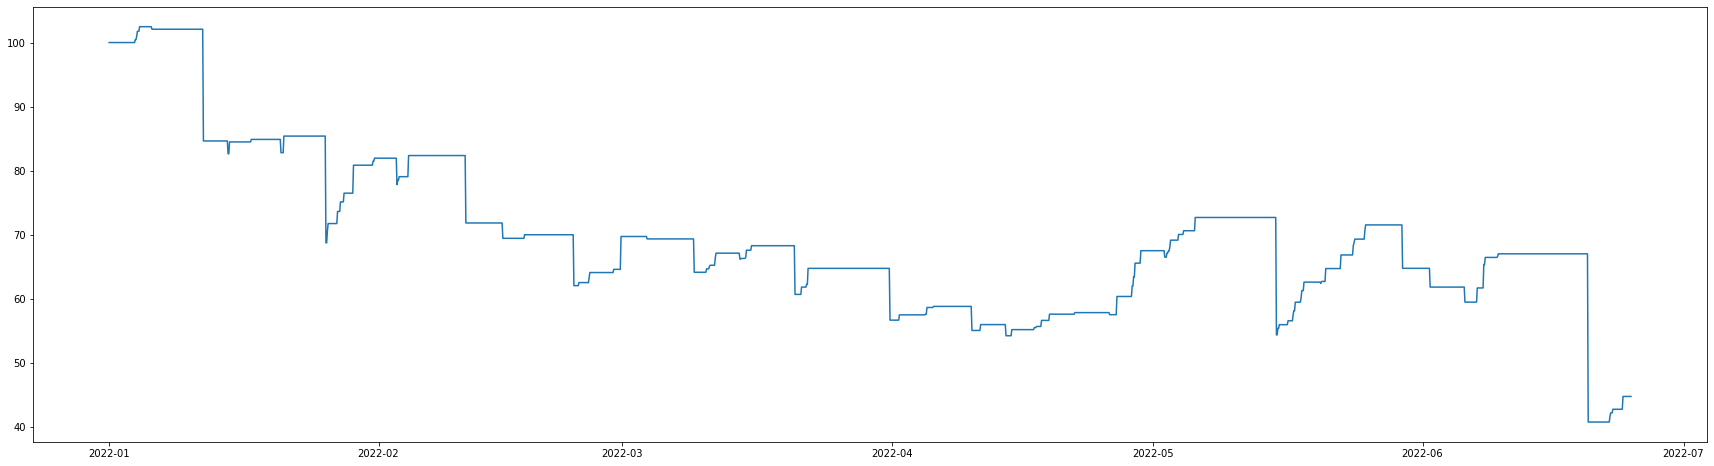

In [18]:
if reinvest_profit_flag == True:
    fig, ax = plt.subplots(figsize=(30, 8))
    ax.plot(budget_dict['time'], budget_dict['budget'])
else:
    print("Not reinvest profit")

In [19]:
if reinvest_profit_flag == True:
    print(f"Max drawdown: {round(max_drawdown * 100, 2)}%")

Max drawdown: 51.33%


In [20]:
win_rate = len(transaction_df[transaction_df['profit'] > 0]) / len(transaction_df)
print(f"Win rate: {round(win_rate * 100, 2)}%")

Win rate: 76.11%


In [21]:
for symbol in transaction_df['symbol'].unique():
    symbol_df = transaction_df[transaction_df['symbol'] == symbol]
    win_rate = len(symbol_df[symbol_df['profit'] > 0]) / len(symbol_df)
    print(f"{symbol} win rate: {round(win_rate * 100, 2)}%")

ETH-PERP win rate: 76.11%


In [22]:
print(f"Distribution")
print(pd.DataFrame(transaction_df['profit_percent'].describe()))

Distribution
       profit_percent
count      113.000000
mean        -0.553257
std          6.077470
min        -39.179494
25%          0.157869
50%          0.868482
75%          1.828144
max          7.940398


In [23]:
for symbol in transaction_df['symbol'].unique():
    temp_return = transaction_df[transaction_df['symbol'] == symbol]['profit_percent']
    
    print(f"Distribution {symbol}:")
    print(pd.DataFrame(temp_return.describe()))
    print("\n")

Distribution ETH-PERP:
       profit_percent
count      113.000000
mean        -0.553257
std          6.077470
min        -39.179494
25%          0.157869
50%          0.868482
75%          1.828144
max          7.940398




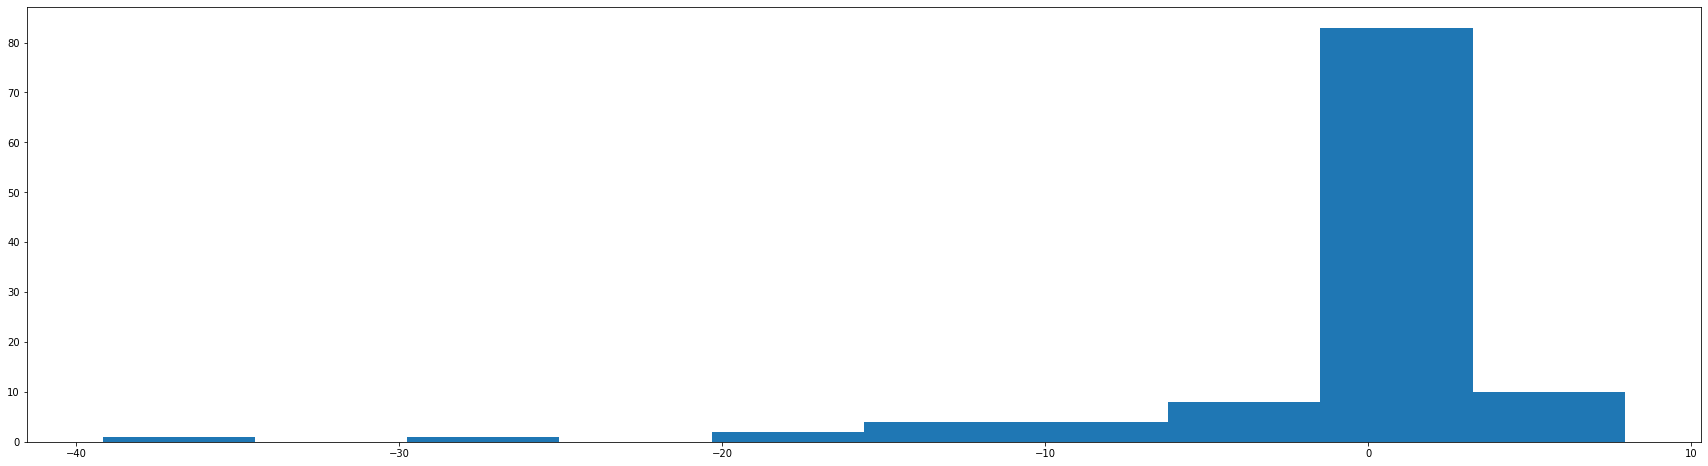

In [24]:
fig, ax = plt.subplots(figsize=(30, 8))
_ = ax.hist(transaction_df['profit_percent'], bins=10)